In [42]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from datasets import load_dataset
import itertools
import random
from itertools import combinations
import os


def calculate_non_overlapping_percentage(
    df, model_column_name="model", lower_column_name="lower", upper_column_name="upper"
):
    """Returns the percentage of non-overlapping intervals."""
    # Extract the model names and intervals
    models = df[model_column_name]
    intervals = df[[lower_column_name, upper_column_name]]

    # Calculate all possible pairs of models
    total_pairs = 0
    non_overlapping_pairs = 0

    for (model1, interval1), (model2, interval2) in combinations(
        zip(models, intervals.itertuples(index=False, name=None)), 2
    ):
        total_pairs += 1
        lower1, upper1 = interval1
        lower2, upper2 = interval2

        # Check if intervals do not overlap
        if upper1 < lower2 or upper2 < lower1:
            non_overlapping_pairs += 1

    # Calculate the percentage of non-overlapping pairs
    if total_pairs > 0:
        percentage = (non_overlapping_pairs / total_pairs) * 100
    else:
        percentage = 0  # In case there are not enough models to form a pair

    return percentage


def get_win_rate_column(df, column, baseline):
    """Uses Terry-Bradley to get the predicted win rate from elo stats for a specific model."""
    to_dict = df[["model", column]].set_index("model").to_dict()[column]
    win_rate_table = predict_win_rate(to_dict)
    return win_rate_table[baseline].fillna(0.5).apply(lambda x: round(x * 100, 2))


def get_win_rate(bootstrap_online_elo, reference_llm_completer):
    """Uses Terry-Bradley to get the predicted win rate from elo stats for all models."""
    stats = pd.DataFrame()
    stats["results"] = None
    stats["results"] = stats["results"].astype("object")

    for i, model in enumerate(bootstrap_online_elo.index):
        stats.at[i, "model"] = model
        stats.at[i, "score"] = bootstrap_online_elo[model]

    return get_win_rate_column(stats, "score", reference_llm_completer)


def predict_win_rate(elo_ratings, SCALE=400, BASE=10, INIT_RATING=1000):
    """Predicts the win rate given ELO ratings, a specified scale, base, and init rating."""
    names = sorted(list(elo_ratings.keys()))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (1 + BASE ** ((elo_ratings[b] - elo_ratings[a]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T


def get_battles_from_judgment(df, WEIGHT=3):
    """Maps battle outcomes to specific winners. The WEIGHT is used to weight strong votes."""
    # Modified from https://github.com/lm-sys/arena-hard-auto/blob/main/show_result.py#L112C1-L176C30
    battles = []
    for _, row in df.iterrows():
        output = {
            "question_id": row["emobench_id"],
            "model_a": row["first_completion_by"],
            "model_b": row["second_completion_by"],
        }

        weight = 1
        if row["pairwise_choice"] == "A=B":
            output["winner"] = "tie"
        elif row["pairwise_choice"] == "A>B":
            output["winner"] = "model_a"
        elif row["pairwise_choice"] == "A>>B":
            output["winner"] = "model_a"
            weight = WEIGHT
        elif row["pairwise_choice"] == "B>A":
            output["winner"] = "model_b"
        elif row["pairwise_choice"] == "B>>A":
            output["winner"] = "model_b"
            weight = WEIGHT
        else:
            print("Unknown pairwise_choice: " + row["pairwise_choice"])

        for i in range(weight):
            battles.append(output)

    return pd.DataFrame(battles)


def compute_mle_elo(df, reference_llm_completer, SCALE=400, BASE=10, INIT_RATING=1000):
    """Compute the ELO scores for all models."""
    df = get_battles_from_judgment(df)

    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "model_a"] = 1.0

    # one tie => one A win + one B win
    # Counts 1 tie as 1 A win and 1 B win, which is why we duplicate the battles.
    tie_idx = df["winner"] == "tie"
    tie_idx[len(tie_idx) // 2 :] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-8)
    lr.fit(X, Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as reference_llm_completer = 1000
    if reference_llm_completer in models.index:
        elo_scores += 1000 - elo_scores[models[reference_llm_completer]]
    return pd.Series(elo_scores, index=models.index).sort_values(ascending=False)


def sample_combinations(items, choose, instances):
    """Generate all possible combinations of the specified size, and sample them randomly."""
    # This is actually fully determinstic for n choose n.
    return [random.choices(items, k=choose) for _ in range(instances)]


def sample_llm_council_members(llm_council_members, k, n):
    """
    Generates a list of n instances, each being a random sample of size k
    from lm_council_members with replacement.

    Parameters:
    llm_council_members (list): The list of council members to sample from.
    k (int): The size of each sample.
    n (int): The number of instances to generate.

    Returns:
    list: A list containing n samples, each of size k.
    """
    return [random.choices(llm_council_members, k=k) for _ in range(n)]


def filter_ratings_by_allowlist(df, llm_judge_allowlist):
    """Filter ratings by a list of allowed judges."""
    return df[df["llm_judge"].isin(llm_judge_allowlist)]


def get_relevant_ratings_for_trial(df, emo_bench_ids, llm_judges, emo_bench_id_and_judge_to_ratings_map):
    # Once the map is prepared, use pd.concat to merge all ratings.
    combined_df = pd.DataFrame()
    for emo_bench_id in emo_bench_ids:
        for llm_judge in llm_judges:
            ratings_for_this_emobench_id_and_llm_judge = (
                emo_bench_id_and_judge_to_ratings_map[emo_bench_id][llm_judge]
            )
            combined_df = pd.concat(
                [combined_df, ratings_for_this_emobench_id_and_llm_judge]
            )

    return combined_df


def get_adversarial_votes(df, num_adversarial_judges):
    """Get a dataframe of adversarial judge ratings (totally random)."""
    all_dfs = [get_adversarial_judge_ratings(df) for i in range(num_adversarial_judges)]
    return pd.concat(all_dfs)


def get_adversarial_judge_ratings(df):
    """Get ratings for adversarial judges."""
    # Extract unique combinations of 'id', 'first_completion_by', 'second_completion_by'
    adversarial_judge_df = df[
        ["emobench_id", "first_completion_by", "second_completion_by"]
    ].drop_duplicates()

    # Assign fixed values
    adversarial_judge_df["llm_judge"] = "adversarial"
    adversarial_judge_df["metadata"] = None

    # Assign random pairwise choices.
    adversarial_judge_df["pairwise_choice"] = np.random.choice(
        ["A>B", "B>A", "A>>B", "B>>A"], size=len(adversarial_judge_df)
    )
    return adversarial_judge_df


def get_simulated_leaderboard_with_adversarial_judges(
    df,
    unique_council_members,
    jury_size,
    num_trials,
    num_adversarial_judges,
    num_adversarial_judges_frac,
    adversarial_method,
    simulation_normalized_number_judges,
    reference_llm_completer,
    num_emobench_ids,
    emo_bench_id_and_judge_to_ratings_map,
):
    """Get a simulated leaderboard with adversarial judges."""
    win_rate_dict = defaultdict(list)
    rank_dict = defaultdict(list)
    elo_dict = defaultdict(list)
    sampled_jury_compositions = sample_combinations(
        unique_council_members, jury_size, num_trials
    )

    council_win_rate_dict = defaultdict(list)
    council_rank_dict = defaultdict(list)
    council_elo_dict = defaultdict(list)

    # Determine the number of adversarial judges.
    num_real_judges = len(sampled_jury_compositions[0])
    if num_adversarial_judges_frac:
        # 1, 0.5 -> 2, 5, 0.5 -> 7
        num_judges_including_adversaries = int(
            num_real_judges / num_adversarial_judges_frac
        )
        num_adversarial_judges = num_judges_including_adversaries - num_real_judges
    elif num_adversarial_judges:
        num_judges_including_adversaries = num_real_judges + num_adversarial_judges
    else:
        num_judges_including_adversaries = num_real_judges
        num_adversarial_judges = 0
    print(f"- Number of judges: {num_real_judges}")
    print(f"- Number of adversarial judges: {num_adversarial_judges}")
    print(
        f"- Number of judges including adversaries: {num_judges_including_adversaries}"
    )

    for sampled_jury_composition in tqdm(sampled_jury_compositions):
        sampled_emobench_ids = sample_combinations(
            df["emobench_id"].unique(), num_emobench_ids, 1
        )[0]
        relevant_ratings = get_relevant_ratings_for_trial(
            df, sampled_emobench_ids, sampled_jury_composition, emo_bench_id_and_judge_to_ratings_map
        )

        # Add adversarial judges, if applicable.
        if num_adversarial_judges:
            adversarial_df = get_adversarial_votes(
                relevant_ratings, num_adversarial_judges
            )
            relevant_ratings = pd.concat([adversarial_df, relevant_ratings])

        # Apply council majority aggregation.
        # This step is important in order to reduce the number of total battles for bootstrapping.
        relevant_ratings = (
            relevant_ratings.groupby(
                ["emobench_id", "first_completion_by", "second_completion_by"]
            )["pairwise_choice"]
            .agg(lambda x: x.mode()[0])
            .reset_index()
        )

        # Compute the ELO and bootstrap them.
        bootstrap_online_elo = compute_mle_elo(
            relevant_ratings, reference_llm_completer
        )

        # Save scores and win rates.
        for llm_completer, elo_score in bootstrap_online_elo.to_dict().items():
            elo_dict[llm_completer].append(elo_score)

        win_rates = get_win_rate(bootstrap_online_elo, reference_llm_completer)
        for llm_completer, win_rate in win_rates.to_dict().items():
            win_rate_dict[llm_completer].append(win_rate)

        ranks = bootstrap_online_elo.rank(method="min", ascending=False)
        for llm_completer, rank in ranks.items():
            rank_dict[llm_completer].append(rank)

    stats = pd.DataFrame()
    for i, model in enumerate(bootstrap_online_elo.index):
        stats.at[i, "model"] = model
        stats.at[i, "rank_score"] = np.mean(rank_dict[model])
        stats.at[i, "rank_std"] = np.std(rank_dict[model])
        stats.at[i, "rank_lower"] = np.percentile(rank_dict[model], 2.5)
        stats.at[i, "rank_upper"] = np.percentile(rank_dict[model], 97.5)

        stats.at[i, "elo_score"] = np.mean(elo_dict[model])
        stats.at[i, "elo_std"] = np.std(elo_dict[model])
        stats.at[i, "elo_lower"] = np.percentile(elo_dict[model], 2.5)
        stats.at[i, "elo_upper"] = np.percentile(elo_dict[model], 97.5)

        stats.at[i, "win_rate_score"] = np.mean(win_rate_dict[model])
        stats.at[i, "win_rate_std"] = np.std(win_rate_dict[model])
        stats.at[i, "win_rate_lower"] = np.percentile(win_rate_dict[model], 2.5)
        stats.at[i, "win_rate_upper"] = np.percentile(win_rate_dict[model], 97.5)

    stats["separability"] = calculate_non_overlapping_percentage(
        stats,
        model_column_name="model",
        lower_column_name="win_rate_lower",
        upper_column_name="win_rate_upper",
    )
    return stats


def get_jury_ablation_stats(
    df,
    num_trials,
    unique_council_members,
    num_adversarial_judges,
    num_adversarial_judges_frac,
    adversarial_method,
    reference_llm_completer,
    num_emobench_ids,
    emo_bench_id_and_judge_to_ratings_map,
):
    """Get a simulated leaderboard with number of adversarial judges."""
    jury_ablation_stats_with_adversarial_judges = pd.DataFrame()

    # Map None to 0.
    if num_adversarial_judges is None:
        num_adversarial_judges = 0
    if num_adversarial_judges_frac is None:
        num_adversarial_judges_frac = 0

    if num_adversarial_judges:
        simulation_normalized_number_judges = (
            len(unique_council_members) + num_adversarial_judges
        )
    elif num_adversarial_judges_frac:
        simulation_normalized_number_judges = int(
            len(unique_council_members) / num_adversarial_judges_frac
        )
    else:
        simulation_normalized_number_judges = len(unique_council_members)
    print(
        f"Number of situation-normalized council members: {simulation_normalized_number_judges}"
    )

    for jury_size in range(1, len(unique_council_members) + 1):
        print(f"Evaluating jury size: {jury_size}")
        num_retries_left = 3
        while num_retries_left > 0:
            try:
                stats = get_simulated_leaderboard_with_adversarial_judges(
                    df,
                    unique_council_members,
                    jury_size,
                    num_trials,
                    num_adversarial_judges,
                    num_adversarial_judges_frac,
                    adversarial_method,
                    simulation_normalized_number_judges,
                    reference_llm_completer,
                    num_emobench_ids,
                    emo_bench_id_and_judge_to_ratings_map,
                )
                break
            except Exception as e:
                print(f"Encountered separability issue: {e}")
                import traceback

                traceback.print_exc()
                num_retries_left -= 1

        jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.mean"] = (
            stats["rank_std"].mean()
        )
        print(stats["rank_std"].mean())
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.std"] = (
            stats["rank_std"].std()
        )
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "rank_std.ci.upper"
        ] = np.percentile(stats["rank_std"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "rank_std.ci.lower"
        ] = np.percentile(stats["rank_std"], 2.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "rank_std.mean.std_upper"
        ] = jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.mean"] + jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.std"]
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "rank_std.mean.std_lower"
        ] = jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.mean"] - jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.std"]
        
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "elo_std.mean"] = (
            stats["elo_std"].mean()
        )
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "elo_std.std"] = (
            stats["elo_std"].std()
        )
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "elo_std.ci.upper"
        ] = np.percentile(stats["elo_std"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "elo_std.ci.lower"
        ] = np.percentile(stats["elo_std"], 2.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.mean"
        ] = stats["win_rate_std"].mean()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.std"
        ] = stats["win_rate_std"].std()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.ci.upper"
        ] = np.percentile(stats["win_rate_std"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.ci.lower"
        ] = np.percentile(stats["win_rate_std"], 2.5)

        # Separability
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.mean"
        ] = stats["separability"].mean()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.std"
        ] = stats["separability"].std()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.ci.upper"
        ] = np.percentile(stats["separability"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.ci.lower"
        ] = np.percentile(stats["separability"], 2.5)

    print("Finished jury ablation.")
    return jury_ablation_stats_with_adversarial_judges

In [5]:
# Read the data.
dataset = load_dataset("llm-council/emotional_application", "response_judging")
df = dataset["council"].to_pandas()

In [6]:
# There can be repeated members in both cases, assuming we are sampling with replacement.
# First get a map of (emo_bench_id, llm_judge) -> relevant ratings.
emo_bench_id_and_judge_to_ratings_map = defaultdict(dict)
for emo_bench_id in df["emobench_id"].unique():
    for llm_judge in df["llm_judge"].unique():
        df_subset = df[df["emobench_id"] == emo_bench_id]
        emo_bench_id_and_judge_to_ratings_map[emo_bench_id][llm_judge] = (
            filter_ratings_by_allowlist(df_subset, [llm_judge])
        )

# Plot

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_jury_ablation(
    jury_ablation_stats_map, 
    main_stat_name, 
    main_stat, 
    main_stat_upper,
    main_stat_lower, 
    # title1, 
    # title2,
    num_trials,
    num_data_ids,
):
    # Create a new figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Collect all unique jury sizes for setting x-ticks
    all_jury_sizes = []

    # Plot the first subplot (Variance of assigned rankings)
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        # Append the jury sizes to the list
        all_jury_sizes.extend(jury_ablation_stats.index.astype(int).tolist())
        
        axes[0].errorbar(
            jury_ablation_stats.index.astype(int),
            jury_ablation_stats[main_stat],
            # yerr=[
            #     jury_ablation_stats[main_stat] - jury_ablation_stats[main_stat_lower],
            #     jury_ablation_stats[main_stat_upper] - jury_ablation_stats[main_stat],
            # ],
            fmt='-o',  # 'o' for circular markers
            label=label,
            color=color,
            capsize=3,  # Add caps to the error bars
        )

    xticks = sorted(set(all_jury_sizes))
    # Select every 5th tick
    xticks = [tick for i, tick in enumerate(xticks) if i % 5 == 0 or i == len(xticks) - 1]
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticks, fontsize=12)
    axes[0].set_xlabel("# Non-Adversarial Jury Members", fontsize=12)
    axes[0].set_title("Mean Expected Rank Variance (MERV)", fontsize=12)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=12)

    # Plot the second subplot (Separability)
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        df = pd.DataFrame({
            'Jury Size': jury_ablation_stats.index.astype(int),  # Convert to numerical
            'Separability': jury_ablation_stats['separability.mean']
        })
        
        all_jury_sizes.extend(df['Jury Size'].unique())

        sns.regplot(
            ax=axes[1],
            x='Jury Size', 
            y='Separability', 
            data=df, 
            label=label, 
            color=color, 
            scatter_kws={'s': 50},  # Size of points
            line_kws={'linestyle': ':'}  # Dotted trendline
        )

    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(xticks, fontsize=12)
    axes[1].set_xlabel("# Non-Adversarial Jury Members", fontsize=12)
    axes[1].set_ylabel("", fontsize=12)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=12)
    axes[1].set_title("Separability (%)", fontsize=12)

    # Create a single legend for both subplots
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(jury_ablation_stats_map), fontsize=12)

    # Adjust layout to make room for the shared legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    # plt.savefig("/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/conversational_response_judging.100_to_200.qwen_32b_reference/jury_ablation_combined.pdf")
    plt.savefig(f"/Users/justinzhao/Repos/llm-council-public/analysis/jury_ablation_charts/jury_ablation_n{num_trials}.data_size{num_data_ids}.pdf")
    plt.show()

# Run simulation and plot

Number of situation-normalized council members: 20
Evaluating jury size: 1
- Number of judges: 1
- Number of adversarial judges: 0
- Number of judges including adversaries: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


2.631938833557138
Evaluating jury size: 2
- Number of judges: 2
- Number of adversarial judges: 0
- Number of judges including adversaries: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]


2.568037908047896
Evaluating jury size: 3
- Number of judges: 3
- Number of adversarial judges: 0
- Number of judges including adversaries: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.11it/s]


2.364780714375274
Evaluating jury size: 4
- Number of judges: 4
- Number of adversarial judges: 0
- Number of judges including adversaries: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.03it/s]


2.0682146797843775
Evaluating jury size: 5
- Number of judges: 5
- Number of adversarial judges: 0
- Number of judges including adversaries: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.95it/s]


1.8620616681688975
Evaluating jury size: 6
- Number of judges: 6
- Number of adversarial judges: 0
- Number of judges including adversaries: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.97it/s]


1.8391152767940055
Evaluating jury size: 7
- Number of judges: 7
- Number of adversarial judges: 0
- Number of judges including adversaries: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.14it/s]


1.7634685735557738
Evaluating jury size: 8
- Number of judges: 8
- Number of adversarial judges: 0
- Number of judges including adversaries: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.87it/s]


1.7022243760900757
Evaluating jury size: 9
- Number of judges: 9
- Number of adversarial judges: 0
- Number of judges including adversaries: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


1.8075298574525438
Evaluating jury size: 10
- Number of judges: 10
- Number of adversarial judges: 0
- Number of judges including adversaries: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


1.7350670887854207
Evaluating jury size: 11
- Number of judges: 11
- Number of adversarial judges: 0
- Number of judges including adversaries: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


1.6793826590916257
Evaluating jury size: 12
- Number of judges: 12
- Number of adversarial judges: 0
- Number of judges including adversaries: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


1.6384215588511164
Evaluating jury size: 13
- Number of judges: 13
- Number of adversarial judges: 0
- Number of judges including adversaries: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.30it/s]


1.6742262929793057
Evaluating jury size: 14
- Number of judges: 14
- Number of adversarial judges: 0
- Number of judges including adversaries: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


1.5984791016920332
Evaluating jury size: 15
- Number of judges: 15
- Number of adversarial judges: 0
- Number of judges including adversaries: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


1.6021372249379102
Evaluating jury size: 16
- Number of judges: 16
- Number of adversarial judges: 0
- Number of judges including adversaries: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


1.6055063182165064
Evaluating jury size: 17
- Number of judges: 17
- Number of adversarial judges: 0
- Number of judges including adversaries: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.42it/s]


1.590464193254728
Evaluating jury size: 18
- Number of judges: 18
- Number of adversarial judges: 0
- Number of judges including adversaries: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


1.552759009979936
Evaluating jury size: 19
- Number of judges: 19
- Number of adversarial judges: 0
- Number of judges including adversaries: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]


1.5327660452622847
Evaluating jury size: 20
- Number of judges: 20
- Number of adversarial judges: 0
- Number of judges including adversaries: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


1.5290003546646427
Finished jury ablation.
Number of situation-normalized council members: 30
Evaluating jury size: 1
- Number of judges: 1
- Number of adversarial judges: 10
- Number of judges including adversaries: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.16it/s]


5.431767251758985
Evaluating jury size: 2
- Number of judges: 2
- Number of adversarial judges: 10
- Number of judges including adversaries: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.13it/s]


4.791848886010403
Evaluating jury size: 3
- Number of judges: 3
- Number of adversarial judges: 10
- Number of judges including adversaries: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.83it/s]


4.064052238305727
Evaluating jury size: 4
- Number of judges: 4
- Number of adversarial judges: 10
- Number of judges including adversaries: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.38it/s]


3.3568808013793037
Evaluating jury size: 5
- Number of judges: 5
- Number of adversarial judges: 10
- Number of judges including adversaries: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.03it/s]


2.958928169037992
Evaluating jury size: 6
- Number of judges: 6
- Number of adversarial judges: 10
- Number of judges including adversaries: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.18it/s]


2.593184426480204
Evaluating jury size: 7
- Number of judges: 7
- Number of adversarial judges: 10
- Number of judges including adversaries: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


2.4720286461765837
Evaluating jury size: 8
- Number of judges: 8
- Number of adversarial judges: 10
- Number of judges including adversaries: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


2.081446636150808
Evaluating jury size: 9
- Number of judges: 9
- Number of adversarial judges: 10
- Number of judges including adversaries: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


1.97469234019629
Evaluating jury size: 10
- Number of judges: 10
- Number of adversarial judges: 10
- Number of judges including adversaries: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


2.0006943877856567
Evaluating jury size: 11
- Number of judges: 11
- Number of adversarial judges: 10
- Number of judges including adversaries: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


1.7670665675222879
Evaluating jury size: 12
- Number of judges: 12
- Number of adversarial judges: 10
- Number of judges including adversaries: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


1.7750523820385922
Evaluating jury size: 13
- Number of judges: 13
- Number of adversarial judges: 10
- Number of judges including adversaries: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]


1.7033071256136012
Evaluating jury size: 14
- Number of judges: 14
- Number of adversarial judges: 10
- Number of judges including adversaries: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.10it/s]


1.6486550391313082
Evaluating jury size: 15
- Number of judges: 15
- Number of adversarial judges: 10
- Number of judges including adversaries: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


1.587830440184075
Evaluating jury size: 16
- Number of judges: 16
- Number of adversarial judges: 10
- Number of judges including adversaries: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


1.606799018303582
Evaluating jury size: 17
- Number of judges: 17
- Number of adversarial judges: 10
- Number of judges including adversaries: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


1.6040255237058934
Evaluating jury size: 18
- Number of judges: 18
- Number of adversarial judges: 10
- Number of judges including adversaries: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.03it/s]


1.6083732049659996
Evaluating jury size: 19
- Number of judges: 19
- Number of adversarial judges: 10
- Number of judges including adversaries: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


1.5325818011780892
Evaluating jury size: 20
- Number of judges: 20
- Number of adversarial judges: 10
- Number of judges including adversaries: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


1.536205340068674
Finished jury ablation.
Number of situation-normalized council members: 40
Evaluating jury size: 1
- Number of judges: 1
- Number of adversarial judges: 1
- Number of judges including adversaries: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.29it/s]


4.062647687976946
Evaluating jury size: 2
- Number of judges: 2
- Number of adversarial judges: 2
- Number of judges including adversaries: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.27it/s]


3.4961759876931127
Evaluating jury size: 3
- Number of judges: 3
- Number of adversarial judges: 3
- Number of judges including adversaries: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.85it/s]


2.986904856401533
Evaluating jury size: 4
- Number of judges: 4
- Number of adversarial judges: 4
- Number of judges including adversaries: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.63it/s]


2.63607873449363
Evaluating jury size: 5
- Number of judges: 5
- Number of adversarial judges: 5
- Number of judges including adversaries: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.05it/s]


2.3724503388294282
Evaluating jury size: 6
- Number of judges: 6
- Number of adversarial judges: 6
- Number of judges including adversaries: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.78it/s]


2.1447791271979932
Evaluating jury size: 7
- Number of judges: 7
- Number of adversarial judges: 7
- Number of judges including adversaries: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


2.137125684786416
Evaluating jury size: 8
- Number of judges: 8
- Number of adversarial judges: 8
- Number of judges including adversaries: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.65it/s]


2.011402032691268
Evaluating jury size: 9
- Number of judges: 9
- Number of adversarial judges: 9
- Number of judges including adversaries: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


1.9168089785684461
Evaluating jury size: 10
- Number of judges: 10
- Number of adversarial judges: 10
- Number of judges including adversaries: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


2.0137065153451834
Evaluating jury size: 11
- Number of judges: 11
- Number of adversarial judges: 11
- Number of judges including adversaries: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]


1.8735225687331323
Evaluating jury size: 12
- Number of judges: 12
- Number of adversarial judges: 12
- Number of judges including adversaries: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.50it/s]


1.784124503712118
Evaluating jury size: 13
- Number of judges: 13
- Number of adversarial judges: 13
- Number of judges including adversaries: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]


1.7478516887613176
Evaluating jury size: 14
- Number of judges: 14
- Number of adversarial judges: 14
- Number of judges including adversaries: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


1.7172958207252236
Evaluating jury size: 15
- Number of judges: 15
- Number of adversarial judges: 15
- Number of judges including adversaries: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.59it/s]


1.7444513821806567
Evaluating jury size: 16
- Number of judges: 16
- Number of adversarial judges: 16
- Number of judges including adversaries: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


1.728635005842754
Evaluating jury size: 17
- Number of judges: 17
- Number of adversarial judges: 17
- Number of judges including adversaries: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


1.5891090434439439
Evaluating jury size: 18
- Number of judges: 18
- Number of adversarial judges: 18
- Number of judges including adversaries: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


1.6854114839043663
Evaluating jury size: 19
- Number of judges: 19
- Number of adversarial judges: 19
- Number of judges including adversaries: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


1.6197357000572334
Evaluating jury size: 20
- Number of judges: 20
- Number of adversarial judges: 20
- Number of judges including adversaries: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


1.6541032997376086
Finished jury ablation.


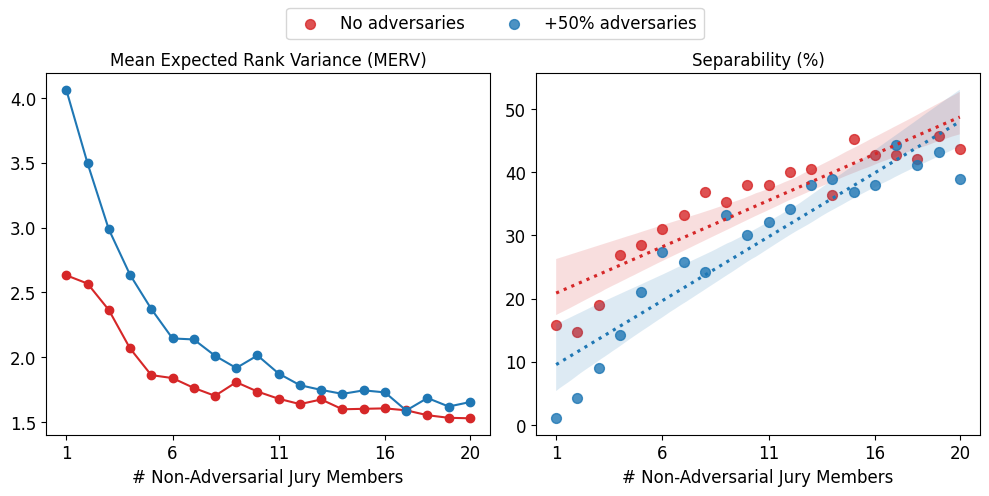

In [67]:
# Without adversarial judges.
num_trials = 100
num_emobench_ids = 30

outdir = "/Users/justinzhao/Repos/llm-council-public/analysis/"

jury_ablation_stats = get_jury_ablation_stats(
    df=df,
    unique_council_members=df["llm_judge"].unique(),
    num_trials=num_trials,
    num_adversarial_judges=None,
    num_adversarial_judges_frac=None,
    adversarial_method=None,
    reference_llm_completer="qwen1.5-32B-Chat",
    num_emobench_ids=num_emobench_ids,
    emo_bench_id_and_judge_to_ratings_map=emo_bench_id_and_judge_to_ratings_map,
)
jury_ablation_stats.to_json(
    os.path.join(outdir, f"no_adversaries.n{num_trials}.data_size{num_emobench_ids}.json"))

# With a fixed number of adversarial judges.
jury_ablation_stats_with_adversarial_judges = get_jury_ablation_stats(
    df=df,
    unique_council_members=df["llm_judge"].unique(),
    num_trials=num_trials,
    num_adversarial_judges=10,
    num_adversarial_judges_frac=None,
    adversarial_method="random",
    reference_llm_completer="qwen1.5-32B-Chat",
    num_emobench_ids=num_emobench_ids,
    emo_bench_id_and_judge_to_ratings_map=emo_bench_id_and_judge_to_ratings_map,
)
jury_ablation_stats_with_adversarial_judges.to_json(
    os.path.join(outdir, f"fixed_adversaries.10.n{num_trials}.data_size{num_emobench_ids}.json"))

# A fixed percentage of adversarial members.
jury_ablation_stats_with_adversarial_judges_fixed_percentage = get_jury_ablation_stats(
    df=df,
    unique_council_members=df["llm_judge"].unique(),
    num_trials=num_trials,
    num_adversarial_judges=None,
    num_adversarial_judges_frac=0.5,
    adversarial_method="random",
    reference_llm_completer="qwen1.5-32B-Chat",
    num_emobench_ids=num_emobench_ids,
    emo_bench_id_and_judge_to_ratings_map=emo_bench_id_and_judge_to_ratings_map,
)
jury_ablation_stats_with_adversarial_judges_fixed_percentage.to_json(
    os.path.join(outdir, f"percentage_adversaries.50.n{num_trials}.data_size{num_emobench_ids}.json"))


plot_combined_jury_ablation(
    jury_ablation_stats_map={
        ("No adversaries", "tab:red"): jury_ablation_stats,
        # ("+10 adversaries", "tab:green"): jury_ablation_stats_with_adversarial_judges,
        ("+50% adversaries", "tab:blue"): jury_ablation_stats_with_adversarial_judges_fixed_percentage,
    },
    main_stat_name="rank σ",
    main_stat="rank_std.mean", 
    # main_stat_upper="rank_std.ci.upper", 
    main_stat_upper="rank_std.mean.std_upper", 
    # main_stat_lower="rank_std.ci.lower",
    main_stat_lower="rank_std.mean.std_lower",
    # title1="Variance of assigned LLM rankings over simulated jury compositions (n=100)",
    # title2="Separability over simulated jury compositions (n=100)",
    num_trials=num_trials,
    num_data_ids=num_emobench_ids,
)


# Plotting code

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set global font size variable
font_size = 24

# Update global font size
plt.rcParams.update({'font.size': font_size})

def plot_combined_jury_ablation(
    jury_ablation_stats_map, 
    main_stat_name, 
    main_stat, 
    main_stat_upper,
    main_stat_lower, 
    num_trials,
    num_data_ids,
):
    # Create a new figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Collect all unique jury sizes for setting x-ticks
    all_jury_sizes = []

    # Plot the first subplot (Variance of assigned rankings)
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        # Append the jury sizes to the list
        all_jury_sizes.extend(jury_ablation_stats.index.astype(int).tolist())
        
        axes[0].errorbar(
            jury_ablation_stats.index.astype(int),
            jury_ablation_stats[main_stat],
            fmt='-o',  # 'o' for circular markers
            label=label,
            color=color,
            capsize=3,  # Add caps to the error bars
            markersize=10  # Increase the size of the dots
        )

    xticks = sorted(set(all_jury_sizes))
    # Use custom xticks for x-axis
    xticks = [tick for i, tick in enumerate(xticks) if i in [0, 4, 9, 14, 19]]
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticks)
    axes[0].set_ylabel("MERV")  # Move title to y-axis label
    y_max = 6
    axes[0].set_yticks(np.arange(1.0, y_max + 1.0, 1.0))  # Set y-ticks from 1 to 6 with step 1

    axes[0].tick_params(axis='both', which='major')
    axes[0].tick_params(axis='both', which='minor')

    # Plot the second subplot (Separability) with connected dots
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        df = pd.DataFrame({
            'Jury Size': jury_ablation_stats.index.astype(int),  # Convert to numerical
            'Separability': jury_ablation_stats['separability.mean']
        })
        
        all_jury_sizes.extend(df['Jury Size'].unique())

        # Plot dots
        axes[1].plot(
            df['Jury Size'],
            df['Separability'],
            'o-',  # 'o' for dots, '-' for connecting line
            label=label,
            color=color,
            markersize=10  # Increase size of points
        )

    axes[1].set_xlabel("")
    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(xticks)
    axes[1].set_ylabel("Separability (%)")  # Move title to y-axis label

    axes[1].tick_params(axis='both', which='major')
    axes[1].tick_params(axis='both', which='minor')

    # Create a single legend for both subplots
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(jury_ablation_stats_map), fontsize=20)

    # Set a shared x-axis label for both subplots
    fig.supxlabel("# Non-Adversarial Jury Members", fontsize=font_size, y=0.1)

    # Adjust layout to make room for the shared legend
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig(f"/Users/justinzhao/Repos/llm-council-public/analysis/jury_ablation_charts/jury_ablation_n{num_trials}.data_size{num_data_ids}.pdf")
    plt.show()


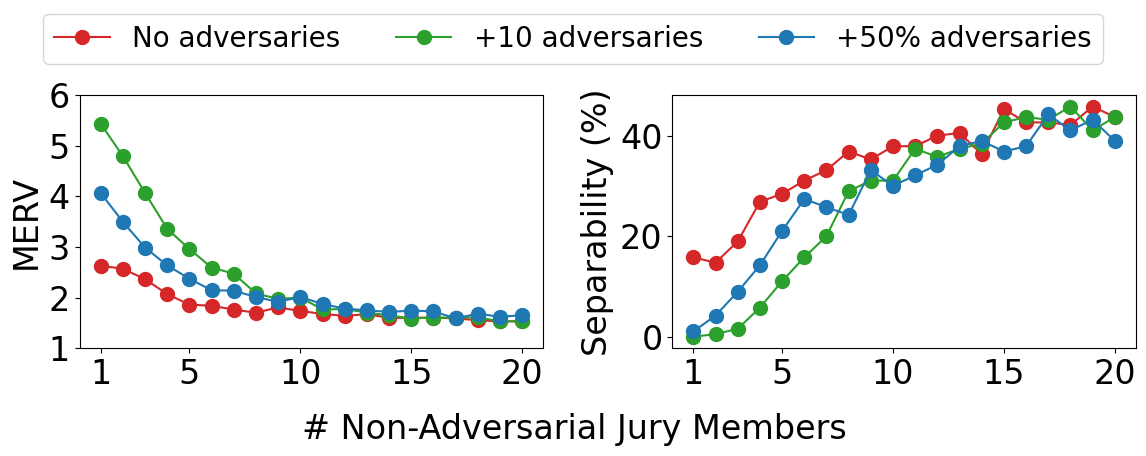

In [160]:
plot_combined_jury_ablation(
    jury_ablation_stats_map={
        ("No adversaries", "tab:red"): jury_ablation_stats,
        ("+10 adversaries", "tab:green"): jury_ablation_stats_with_adversarial_judges,
        ("+50% adversaries", "tab:blue"): jury_ablation_stats_with_adversarial_judges_fixed_percentage,
    },
    main_stat_name="rank σ",
    main_stat="rank_std.mean", 
    # main_stat_upper="rank_std.ci.upper", 
    main_stat_upper="rank_std.mean.std_upper", 
    # main_stat_lower="rank_std.ci.lower",
    main_stat_lower="rank_std.mean.std_lower",
    # title1="Variance of assigned LLM rankings over simulated jury compositions (n=100)",
    # title2="Separability over simulated jury compositions (n=100)",
    num_trials=num_trials,
    num_data_ids=num_emobench_ids,
)


# Single plot

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Set global font size variable
font_size = 20

# Update global font size
plt.rcParams.update({'font.size': font_size})

def plot_single_jury_ablation(
    jury_ablation_stats_map, 
    main_stat_name, 
    main_stat, 
    main_stat_upper,
    main_stat_lower, 
    num_trials,
    num_data_ids,
):
    # Create a new figure for a single plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Collect all unique jury sizes for setting x-ticks
    all_jury_sizes = []

    # Plot the single plot (Variance of assigned rankings)
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        # Append the jury sizes to the list
        all_jury_sizes.extend(jury_ablation_stats.index.astype(int).tolist())
        
        ax.errorbar(
            jury_ablation_stats.index.astype(int),
            jury_ablation_stats[main_stat],
            fmt='-o',  # 'o' for circular markers
            label=label,
            color=color,
            capsize=3,  # Add caps to the error bars
            markersize=10  # Increase the size of the dots
        )

    xticks = sorted(set(all_jury_sizes))
    # Select specific ticks for x-axis
    xticks = [tick for i, tick in enumerate(xticks) if i in [0, 4, 9, 14, 19]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel("# Non-Adversarial Jury Members")
    ax.set_ylabel("MERV")

    # Ensure every whole number on the y-axis is labeled, up to 6.0
    y_max = 6
    ax.set_yticks(np.arange(1.0, y_max + 1.0, 1.0))  # Set y-ticks from 1 to 6 with step 1

    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')

    # Create a single legend
    ax.legend(loc='upper right', fontsize=18)

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(f"/Users/justinzhao/Repos/llm-council-public/analysis/jury_ablation_charts/jury_ablation_n{num_trials}.data_size{num_data_ids}.pdf")
    plt.show()


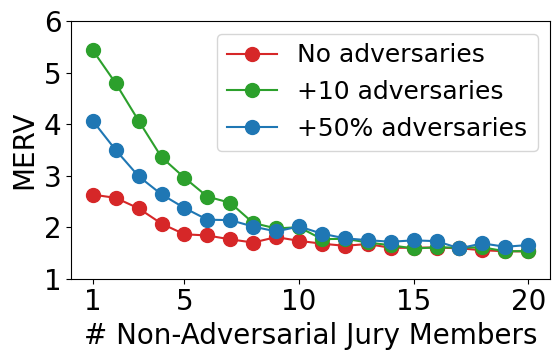

In [108]:
plot_single_jury_ablation(
    jury_ablation_stats_map={
        ("No adversaries", "tab:red"): jury_ablation_stats,
        ("+10 adversaries", "tab:green"): jury_ablation_stats_with_adversarial_judges,
        ("+50% adversaries", "tab:blue"): jury_ablation_stats_with_adversarial_judges_fixed_percentage,
    },
    main_stat_name="rank σ",
    main_stat="rank_std.mean", 
    main_stat_upper="rank_std.mean.std_upper", 
    main_stat_lower="rank_std.mean.std_lower",
    num_trials=num_trials,
    num_data_ids=num_emobench_ids,
)
